In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import numpy as np
import pandas as pd
import tidybear as tb

import matplotlib.pyplot as plt
from plotnine import *
%matplotlib inline

In [3]:
# create discography dataframe

albums = json.load(open("foo_fighter_discography.json"))

from lib.spotify.models import AlbumList
album_list = AlbumList(**albums)

discography = album_list.to_frame() \
    .rename(columns={"duration_ms": "duration"}) \
    .assign(duration = lambda x: x.duration / 1000 / 60)

# create setlist dataframe

concerts = pd.read_csv("data/concerts.csv")
songs = pd.read_csv("data/songs.csv")

setlists = songs \
    .merge(concerts, how="left", left_on="concert_id", right_on="id") \
    .query("not is_cover") \
    .loc[:, ["event_date", "name"]] \
    .drop_duplicates() \
    .rename({"event_date": "performed"}, axis=1)

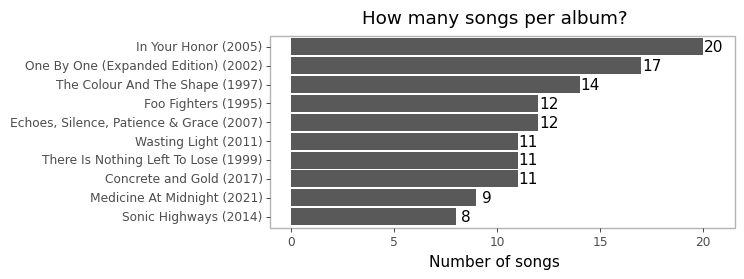

<ggplot: (106331552154)>

In [76]:
data = discography.copy()

get_display_name = lambda x: f"{x.album_name} ({x.released.year})"
data["display_name"] = data.apply(get_display_name, axis=1)

(
    ggplot(
        aes("reorder(display_name, n)", "n"), 
        tb.count(data, "display_name")
    ) +
    geom_col() +
    coord_flip() + 
    geom_text(aes(label="n"), nudge_y=.5) +
    labs(
        title="How many songs per album?",
        x=None, y="Number of songs"
    ) +
    theme_light() + 
    theme(
        panel_grid=element_blank(),
        figure_size=(6,2.5)
    )
)

In [52]:
data = discography.copy()

data["display_name"] = data.apply(get_display_name, axis=1)
data["release_year"] = data.released.dt.year

data = data[["display_name", "name", "release_year"] + data.columns[5:-2].tolist()] \
    .drop(columns=["time_signature", "key", "mode"]) \
    .set_index(["display_name", "release_year", "name"]).stack().reset_index()

data = tb.rename(data, "album", "year", "song", "metric", "value")
data = data.groupby(["album", "year", "metric"]).value.mean().rename("mean_value").reset_index()

audio_features_tidy = data.copy()

[print(x) for x in audio_features_tidy.metric.unique()];

acousticness
danceability
duration
energy
instrumentalness
liveness
loudness
speechiness
tempo
valence


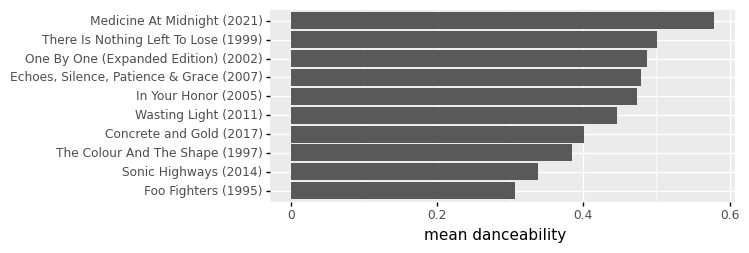

<ggplot: (106332615090)>

In [60]:
feat = "danceability"

(
    ggplot(
        aes("reorder(album, mean_value)", "mean_value"), 
        audio_features_tidy.query(f"metric == '{feat}'") 
    ) + 
    geom_col() + 
    coord_flip() +
    labs(x=None, y=f"mean {feat}") +
    theme(figure_size=(6, 2.5)) 
)

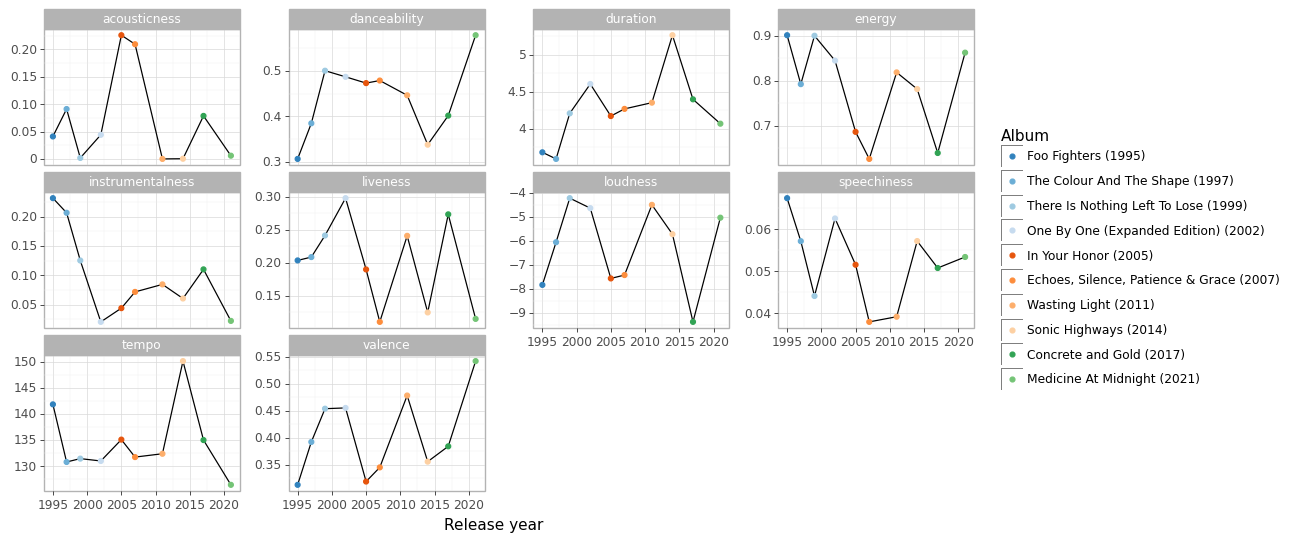

<ggplot: (106323503595)>

In [75]:
(
    ggplot(aes("year", "mean_value"), audio_features_tidy) + 
    geom_line() + 
    geom_point(aes(color="reorder(album, year)")) + 
    scale_color_ordinal("tab20c") +
    facet_wrap("metric", scales="free_y") + 
    labs(y=None, x="Release year", color="Album") +
    theme_light() + 
    theme(
        figure_size=(12, 6),
        subplots_adjust={'wspace': 0.25}
    )
)